### Measuring Entity Susceptibility Scores in Movie Reviews with Conditional MI

In [21]:
import yaml
from itertools import product
import pandas as pd
import seaborn as sns
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
import numpy as np
import math
import statsmodels.api as sm

In [2]:
with open('toy_movie_reviews.yaml', 'r') as file:
    review_adjs = yaml.safe_load(file)

In [3]:
pos_adjs_train = review_adjs["positive_adjectives_train"]
neg_adjs_train = review_adjs["negative_adjectives_train"]

pos_verbs = review_adjs["positive_verbs"]
neg_verbs = review_adjs["negative_verbs"]


In [4]:
movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
movies = movies[["title", "vote_count", "popularity"]].dropna().sort_values(by="vote_count")
movies["popularity"] = movies["popularity"].astype(float)
movies_sample = pd.concat([movies.iloc[:250], movies.iloc[-250:]], axis=0)

/tmp/ipykernel_8681/43001630.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv


In [5]:
movies_sample

,title,vote_count,popularity
45416,"Whiffles, Cubic Artist",0.0,0.003732
45377,Simbad e il califfo di Bagdad,0.0,0.006352
107,Headless Body in Topless Bar,0.0,0.001346
126,Jupiter's Wife,0.0,0.001178
132,Sonic Outlaws,0.0,0.001838
...,...,...,...
26564,Deadpool,11444.0,187.860492
17818,The Avengers,12000.0,89.887648
14551,Avatar,12114.0,185.070892
12481,The Dark Knight,12269.0,123.167259


<Axes: xlabel='vote_count', ylabel='popularity'>

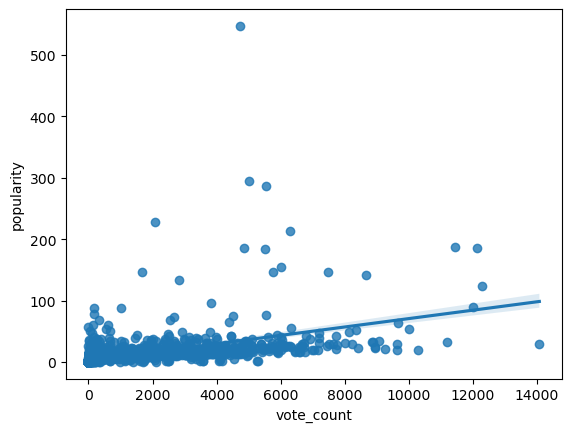

In [6]:
# WHETHER TO USE VOTE COUNT OR POPULARITY

# movies.sort_values(by="popularity").tail(50)
# movies.sort_values(by="vote_count").tail(50)
sns.regplot(data=movies, x="vote_count", y="popularity")

In [7]:
template = "Here's a review for the movie '{}': I thought this movie was {}, I {} it.\nConclusion: This movie is"
template.format(movies_sample["title"].iloc[0], pos_adjs_train[0], pos_verbs[0])
movies_sample["sentence"] = movies_sample["title"].apply(lambda title: template.format(title, pos_adjs_train[0], pos_verbs[0])) 


In [8]:
context_template = "Here's a movie review: 'The movie was {} and I {} it'. "
num_adjs = min(len(pos_adjs_train), len(neg_adjs_train))
num_verbs = min(len(pos_verbs), len(neg_verbs))

pos_contexts = [context_template.format(adj, verb) for (adj, verb) in product(pos_adjs_train[:num_adjs], pos_verbs[:num_verbs])]
neg_contexts = [context_template.format(adj, verb) for (adj, verb) in product(neg_adjs_train[:num_adjs], neg_verbs[:num_verbs])]
contexts = neg_contexts
# contexts = pos_contexts + neg_contexts

print("Number of positive contexts: ", len(pos_contexts))
print("Number of negative contexts: ", len(neg_contexts))
print(contexts[::10])

Number of positive contexts:  72
Number of negative contexts:  72
["Here's a movie review: 'The movie was dreadful and I hated it'. ", "Here's a movie review: 'The movie was depressing and I disliked it'. ", "Here's a movie review: 'The movie was nasty and I despised it'. ", "Here's a movie review: 'The movie was ugly and I hated it'. ", "Here's a movie review: 'The movie was annoying and I disliked it'. ", "Here's a movie review: 'The movie was frustrating and I despised it'. ", "Here's a movie review: 'The movie was unpleasant and I hated it'. ", "Here's a movie review: 'The movie was awful and I disliked it'. "]


In [9]:
def format_query(query, entity, context, prefix=""):
    return prefix + context + query.format(entity)

In [10]:
# from functools import partial
# def fill_in_template(template: str, title: str, adj: str, verb: str):
#     return template.format(title, adj, verb)

# pos_template_partial = partial(fill_in_template, template=template, verb=pos_verbs[0])
# neg_template_partial = partial(fill_in_template, template=template, verb=neg_verbs[0])

# for adj in pos_adjs_train:
#     movies_sample[f"pos_{adj}_context"] = movies_sample["title"].apply(lambda title: pos_template_partial(title=title, adj=adj))

# for adj in neg_adjs_train:
#     movies_sample[f"neg_{adj}_context"] = movies_sample["title"].apply(lambda title: neg_template_partial(title=title, adj=adj))

In [11]:
movies_sample.head()

,title,vote_count,popularity,sentence
45416,"Whiffles, Cubic Artist",0.0,0.003732,"Here's a review for the movie 'Whiffles, Cubic..."
45377,Simbad e il califfo di Bagdad,0.0,0.006352,Here's a review for the movie 'Simbad e il cal...
107,Headless Body in Topless Bar,0.0,0.001346,Here's a review for the movie 'Headless Body i...
126,Jupiter's Wife,0.0,0.001178,Here's a review for the movie 'Jupiter's Wife'...
132,Sonic Outlaws,0.0,0.001838,Here's a review for the movie 'Sonic Outlaws':...


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "EleutherAI/pythia-70m-deduped"


model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  # load_in_8bit=True,
  # revision="step3000",
  # cache_dir="./pythia-70m-deduped/step3000",
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  padding_side="left",
  # revision="step3000",
  # cache_dir="./pythia-70m-deduped/step3000",
)

query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
inputs = tokenizer(format_query(query=query, entity=movies_sample.iloc[0]["title"], context=contexts[0]), return_tensors="pt").to(device)
# inputs = tokenizer(movies_sample.iloc[0]["sentence"], return_tensors="pt").to(device)
tokens = model.generate(**inputs)
probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)
print(sum(probs))
tokenizer.decode(top_tokens)
# print(tokens)
# tokenizer.decode(tokens[0])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 43, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/tmp/ipykernel_8681/362821314.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)


tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


'\n��icedicky001........�icing002'

In [13]:
answer_map = {
    0: ["0", "zero", "Zero"],
    1: ["1", "one", "One"],
    2: ["2", "two", "Two"],
    3: ["3", "three", "Three"],
    4: ["4", "four", "Four"],
    5: ["5", "five", "Five"],
}
answer_map_token_ids = {k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device) for k, v in answer_map.items()}
answer_map_token_ids

{0: tensor([   17, 10528, 26561], device='cuda:0'),
 1: tensor([  18,  531, 4041], device='cuda:0'),
 2: tensor([  19, 9389, 7910], device='cuda:0'),
 3: tensor([   20, 13524, 11831], device='cuda:0'),
 4: tensor([   21, 12496, 14039], device='cuda:0'),
 5: tensor([   22, 12071, 25438], device='cuda:0')}

In [14]:
# 1. Approximate x ∈ Σ∗ with a set of contexts from a dataset
# 2. Approximate p(y|x, q[e]) with monte carlo samples of y given x and q[e].
# 3. Approximate p(y|q[e]) with monte carlo samples of x.
# 4. Approximate p(x) with samples from a corpus (empirical distribution), but meaning/interpretation is complicated.
# Run a model on each of these sentences and get a score


def estimate_prob_x_given_e(entity: str, contexts: List[str]):
    """
    Returns a (len(contexts),) nparray containing the probability of each context.
    """
    return np.ones(len(contexts)) / len(contexts) 

def estimate_prob_next_word_given_x_and_entity(query, entity: str, contexts: List[str], model: GPTNeoXForCausalLM, tokenizer: AutoTokenizer, bs=32, answer_map=None):
    """
    Args:
        entity: str - the entity of interest
        contexts: List[str] - list of contexts appended to the query regarding entity

    Returns:
      samples - a list of torch longtensors of shape (num_samples, max_length) with length len(contexts)
      possible_outputs - a dict mapping from all observed outputs to its unique index.
    """
    complete_queries = [format_query(query, entity, context) for context in contexts]

    if tokenizer.padding_side != "left":
        raise ValueError(f"Expected tokenizer {tokenizer} to have padding side of `left` for batch generation, instead has padding side of `{tokenizer.padding_side}`. Please make sure you initialize the tokenizer to use left padding.")
    
    if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token

    if model.config.pad_token_id != model.config.eos_token_id:
      print("Setting model.config.pad_token_id to model.config.eos_token_id")
      model.config.pad_token_id = model.config.eos_token_id

    output_size = model.config.vocab_size if answer_map is None else len(answer_map)
    num_batches = math.ceil(len(complete_queries) / bs)
    last_word_logits = torch.zeros(len(complete_queries), output_size, device=model.device)
    for b in range(num_batches):
        start, end = b * bs, min((b + 1) * bs, len(complete_queries))
        tokens = tokenizer(complete_queries[start: end], padding=True, return_tensors="pt").to(model.device) # shape: (len(contexts), max_context_width)
        logits = model(**tokens)["logits"] # shape: (len(contexts), mcw, vocab_sz)
        last_word_logits_batch = logits[:, -1, :] # shape: (len(contexts), vocab_sz)
        if answer_map is not None:
            last_word_logits_agg = torch.zeros(end - start, output_size, device=model.device)
            for answer, option_ids in answer_map.items():
                logit_vals = torch.index_select(input=last_word_logits_batch, dim=1, index=option_ids) # shape; (bs, len(option_ids))
                last_word_logits_agg[:, answer] = torch.sum(logit_vals, dim=1)
            last_word_logits_batch = last_word_logits_agg
        last_word_logits[start: end] = last_word_logits_batch

    last_word_probs = torch.nn.functional.softmax(last_word_logits, dim=1) # shape: (len(contexts, vocab_sz))
    # print(last_word_probs.shape)
    # print(torch.sum(last_word_probs, dim=1)[1].item())

    return last_word_probs.cpu().detach().numpy()

def estimate_prob_y_given_context_and_entity(
        query:str, 
        entity: str, 
        contexts: List[str], 
        model: GPTNeoXForCausalLM, 
        tokenizer: AutoTokenizer, 
        num_samples=None,
        max_output_length=1,
        answer_map=None,
    ):
    """
    Args:
        output_samples - a list of sampled outputs from the model given the context and entity. 
                         Outputs need not be unique.

    Returns:
        a (len(set(output_samples)),) nparray containing the probability of each output.
    """
    if max_output_length > 1 and num_samples is None:
        raise ValueError("Estimating p(y | x, q[e]) for outputs y with length >1 requires sampling. Please specify a value for num_samples.")

    if num_samples is not None:
        return sample_y_given_x_and_entity(
            query=query, 
            entity=entity, 
            contexts=contexts, 
            model=model, 
            tokenizer=tokenizer, 
            num_samples=num_samples,
            max_output_length=max_output_length,
        )

    return estimate_prob_next_word_given_x_and_entity(            
        query=query, 
        entity=entity, 
        contexts=contexts, 
        model=model, 
        tokenizer=tokenizer, 
        answer_map=answer_map,
    )
    

def sample_y_given_x_and_entity(query, entity: str, contexts: List[str], model: GPTNeoXForCausalLM, tokenizer: AutoTokenizer, num_samples=1000):
    """
    Args:
        entity: str - the entity of interest
        contexts: List[str] - list of contexts appended to the query regarding entity
    """
    raise NotImplementedError()


def estimate_cmi(query, entity, contexts, model, tokenizer, answer_map=None): 
    """
    Computes the conditional mutual information I(X; Y | q[e]) of answer Y and context X when conditioned on query regarding entity e.

    I(X; Y | q[e]) = \sum_{x \in X} \sum_{y \in Y} (p(x, y | q[e]) * log(p(y | x, q[e]) / p(y | q[e])))

    So we need to monte carlo estimate:
        (1) p(y | x, q[e])                                             , shape: (|X|, |Y|)
        (2) p(x | q[e])                                                , shape: (|X|,)
        (3) p(x, y | q[e]) = p(y | x, q[e]) * p(x | q[e])              , shape: (|X|, |Y|)
        (4) p(y | q[e]) = \sum_{x \in X} (p(y | x, q[e]) * p(x | q[e])), shape: (|Y|,)
    """
    prob_x_given_e = estimate_prob_x_given_e(entity, contexts) # shape: (|X|,)
    # output_samples = sample_y_given_x_and_entity(query, entity, contexts, model, tokenizer) # shape: (|X|,)
    prob_y_given_context_and_entity = estimate_prob_y_given_context_and_entity(query, entity, contexts, model, tokenizer, answer_map=answer_map) # shape: (|X|, |Y|)

    prob_x_y_given_e = np.einsum("ij, i -> ij", prob_y_given_context_and_entity, prob_x_given_e) # shape: (|X|, |Y|)
    prob_y_given_e = np.einsum("ij, i -> j", prob_y_given_context_and_entity, prob_x_given_e) # shape: (|Y|,)
    
    return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))

In [15]:
query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
from tqdm import tqdm
tqdm.pandas()
movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=answer_map_token_ids))

  0%|          | 2/500 [00:00<00:28, 17.67it/s]

Setting model.config.pad_token_id to model.config.eos_token_id


100%|██████████| 500/500 [01:02<00:00,  8.05it/s]


In [16]:
movies_sample.value_counts("susceptibility_score")

susceptibility_score
0.002968    2
0.002508    1
0.002503    1
0.002501    1
0.002496    1
           ..
0.001592    1
0.001588    1
0.001583    1
0.001559    1
0.001666    1
Name: count, Length: 499, dtype: int64

In [17]:
movies_sample

,title,vote_count,popularity,sentence,susceptibility_score
45416,"Whiffles, Cubic Artist",0.0,0.003732,"Here's a review for the movie 'Whiffles, Cubic...",0.001108
45377,Simbad e il califfo di Bagdad,0.0,0.006352,Here's a review for the movie 'Simbad e il cal...,0.002142
107,Headless Body in Topless Bar,0.0,0.001346,Here's a review for the movie 'Headless Body i...,0.001198
126,Jupiter's Wife,0.0,0.001178,Here's a review for the movie 'Jupiter's Wife'...,0.003987
132,Sonic Outlaws,0.0,0.001838,Here's a review for the movie 'Sonic Outlaws':...,0.002723
...,...,...,...,...,...
26564,Deadpool,11444.0,187.860492,Here's a review for the movie 'Deadpool': I th...,0.001295
17818,The Avengers,12000.0,89.887648,Here's a review for the movie 'The Avengers': ...,0.002957
14551,Avatar,12114.0,185.070892,Here's a review for the movie 'Avatar': I thou...,0.002503
12481,The Dark Knight,12269.0,123.167259,Here's a review for the movie 'The Dark Knight...,0.002088


<Axes: xlabel='vote_count', ylabel='susceptibility_score'>

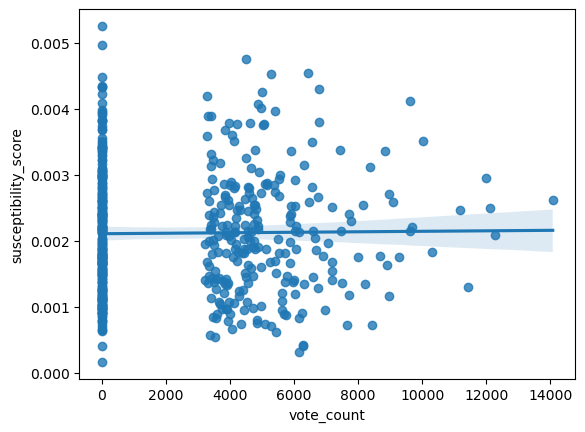

In [19]:
sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score")

In [22]:
x = movies_sample["vote_count"]
x = sm.add_constant(x)
y = movies_sample["susceptibility_score"]
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     susceptibility_score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                   0.06730
Date:                  Wed, 29 Nov 2023   Prob (F-statistic):              0.795
Time:                          23:45:52   Log-Likelihood:                 2781.5
No. Observations:                   500   AIC:                            -5559.
Df Residuals:                       498   BIC:                            -5550.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021   5.57e-05     37.803      0.000       0.002       0.002
vote_count  3.666e-09   1.41e-08      0.259      0.795   -2.41e-08    3.14e-08
==============================================================================
Omnibus:                       21.660   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.789
Skew:                           0.532   Prob(JB):                     6.83e-06
Kurtosis:                       2.894   Cond. No.                     5.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""